<a href="https://www.kaggle.com/code/mgusat/cifar-10-v0-9?scriptVersionId=141094656" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

This notebook achieves 71.8% w/ only basic knowledge of CNNs and pytorch.

## Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
## YOUR CODE HERE ##

# Create training set and define training dataloader
## YOUR CODE HERE ##

# Create test set and define test dataloader
## YOUR CODE HERE ##

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=32, padding=4),  #arguable for such tiny ings...
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create training set and define training dataloader
train_dataset = datasets.CIFAR10('./kaggle/input/cifar-10/train.7z', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
test_dataset = datasets.CIFAR10('./kaggle/input/cifar-10/test.7z', train=False, transform=val_test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define validation set and validation dataloader
val_dataset = datasets.CIFAR10('./kaggle/input/cifar-10/test.7z', train=False, transform=val_test_transform, download=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 81674860.70it/s]


Extracting ./kaggle/input/cifar-10/train.7z/cifar-10-python.tar.gz to ./kaggle/input/cifar-10/train.7z


100%|██████████| 170498071/170498071 [00:02<00:00, 81495306.17it/s]


Extracting ./kaggle/input/cifar-10/test.7z/cifar-10-python.tar.gz to ./kaggle/input/cifar-10/test.7z
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

cat


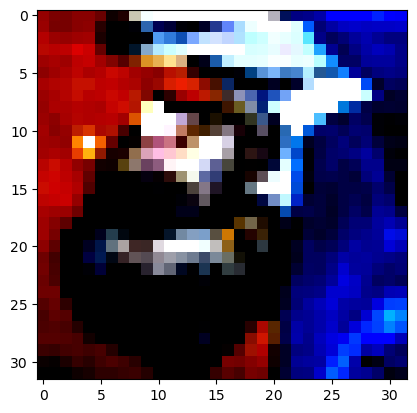

ship


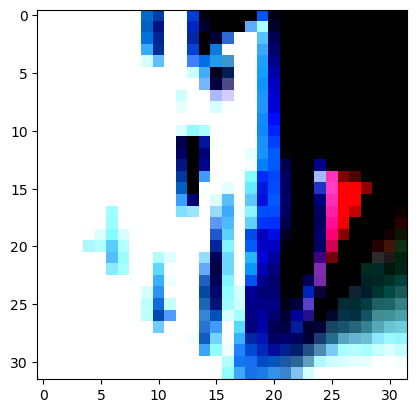

ship


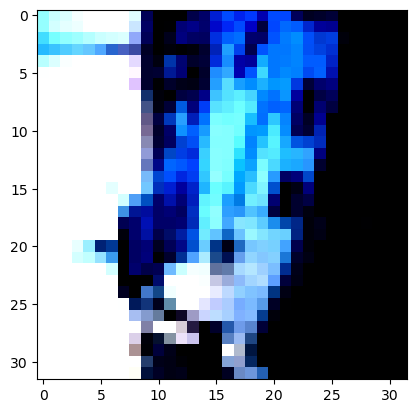

plane


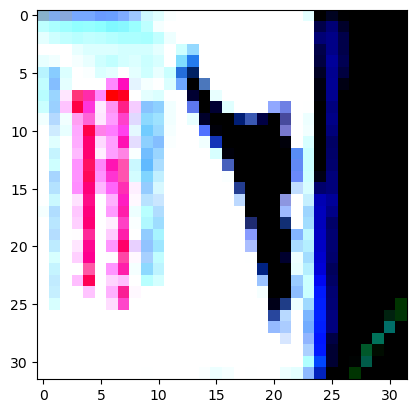

frog


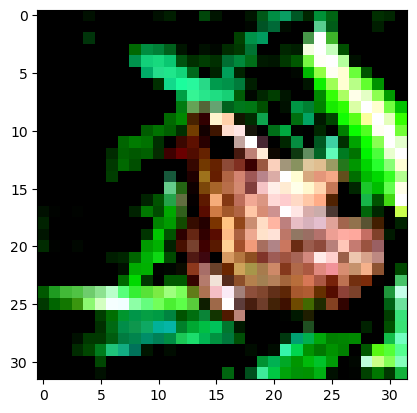

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()
        
# Show 5 sample images from the test dataset (less intrusive transf)
show5(test_loader)

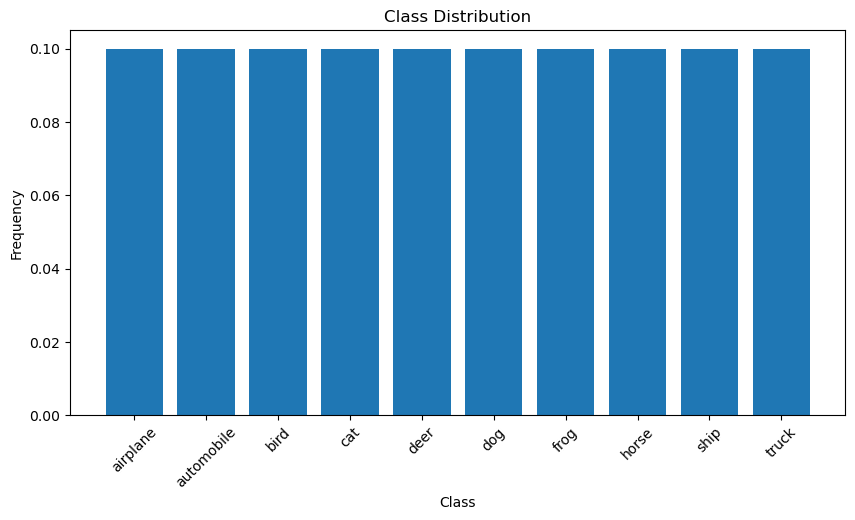

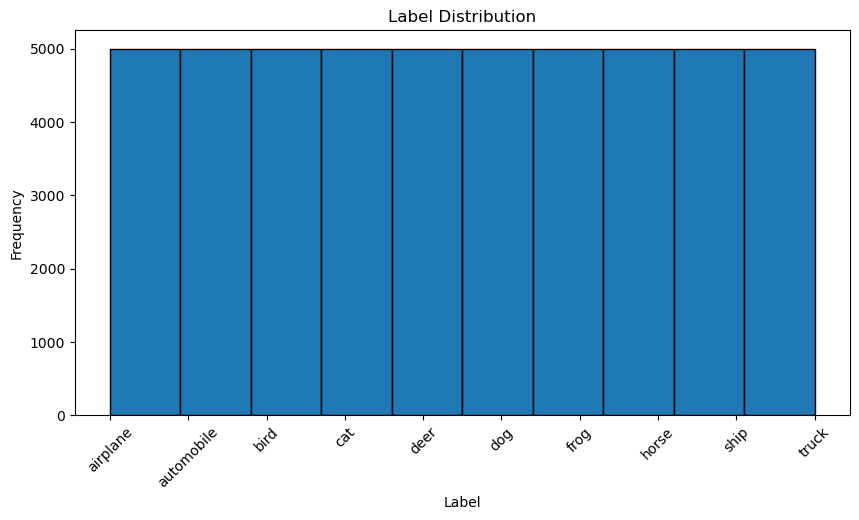

In [5]:
# Explore data
## YOUR CODE HERE ##

# Get class labels
labels = np.array(train_dataset.targets)

# Get class names
classes = train_dataset.classes

# Calculate class frequencies
class_counts = np.bincount(labels)
class_frequencies = class_counts / class_counts.sum()

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(classes, class_frequencies)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

# Plot label distribution
plt.figure(figsize=(10, 5))
plt.hist(labels, bins=len(classes), edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.show()

## Perfect balance on both...!

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
## YOUR CODE HERE ##

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Adjust this based on your input image size
        self.fc2 = nn.Linear(128, 10)  # 10 classes in CIFAR-10
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the CNNClassifier
model = CNNClassifier()

# Print the model's architecture
print(model)


CNNClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [7]:
# Input (3, H, W)
#  |
#  | Conv2d (32 filters, 3x3, padding=1)
#  | ReLU
#  | Conv2d (64 filters, 3x3, padding=1)
#  | ReLU
#  | MaxPool2d (2x2)
#  |
#  | Flatten
#  |
#  | Fully Connected (128 units)
#  | ReLU
#  |
#  | Fully Connected (10 units - output classes)
#  |
# Output (10 classes)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
## YOUR CODE HERE ##
import torch.optim as optim

# Specify the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Specify the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Print the loss function and optimizer
print("Loss Function:", criterion)
print("Optimizer:", optimizer)

# Create an instance of the CNNClassifier => was already instantiated with the CNN arch. above
# model = CNNClassifier()

Loss Function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

Plot the training loss (and validation loss/accuracy, if recorded).

Using cuda
Epoch [1/5], Batch [250/782], Loss: 1.8781
Epoch [1/5], Batch [500/782], Loss: 1.5902
Epoch [1/5], Batch [750/782], Loss: 1.4432
Epoch [1/5], Validation Loss: 1.2495, Validation Accuracy: 0.5551
Epoch [2/5], Batch [250/782], Loss: 1.3133
Epoch [2/5], Batch [500/782], Loss: 1.2501
Epoch [2/5], Batch [750/782], Loss: 1.2071
Epoch [2/5], Validation Loss: 1.0422, Validation Accuracy: 0.6392
Epoch [3/5], Batch [250/782], Loss: 1.1344
Epoch [3/5], Batch [500/782], Loss: 1.1193
Epoch [3/5], Batch [750/782], Loss: 1.0675
Epoch [3/5], Validation Loss: 0.9609, Validation Accuracy: 0.6577
Epoch [4/5], Batch [250/782], Loss: 1.0522
Epoch [4/5], Batch [500/782], Loss: 1.0299
Epoch [4/5], Batch [750/782], Loss: 1.0262
Epoch [4/5], Validation Loss: 0.9133, Validation Accuracy: 0.6851
Epoch [5/5], Batch [250/782], Loss: 0.9873
Epoch [5/5], Batch [500/782], Loss: 1.0126
Epoch [5/5], Batch [750/782], Loss: 0.9912
Epoch [5/5], Validation Loss: 0.8838, Validation Accuracy: 0.6955


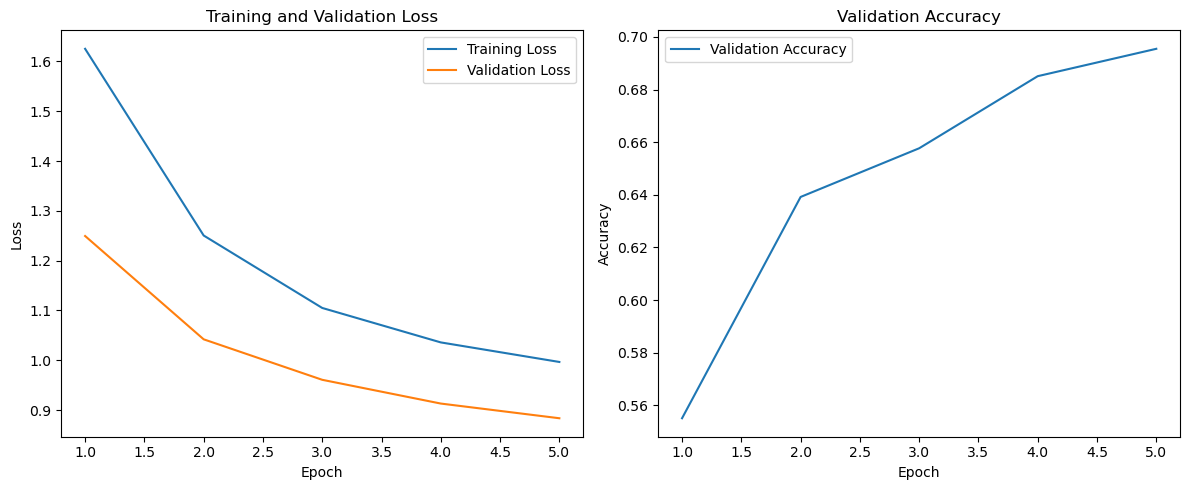

In [9]:
## YOUR CODE HERE ##

# Redo: a new clean re-train d'a cappo for GPU
# Define the CNNClassifier class and other necessary code

# Define the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# Instantiate the model and move it to the device
model = CNNClassifier().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)  #  lr=0.01, momentum=0.9 => 71%

# # Define the hyperparameters for the Adam optimizer
# learning_rate = 0.001
# weight_decay = 1e-4  # or 5e-4
# # Instantiate the Adam optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Lists to store training loss and validation loss/accuracy
train_loss_list = []
val_loss_list = []
val_acc_list = []

# Define the number of epochs
epochs = 5

# Set the model to training mode
model.train()

# Loop over epochs
for epoch in range(epochs):
    running_loss = 0.0
    epoch_loss = 0.0 # Initialize epoch_loss to 0.0
    
    # Loop over batches
    for batch_idx, (inputs, labels) in enumerate(train_loader, 1):
    
        # Move data to the device
        inputs, labels = inputs.to(device), labels.to(device)        
        # Zero the gradients
        optimizer.zero_grad()        
        # Forward pass
        outputs = model(inputs)        
        # Compute the loss
        loss = criterion(outputs, labels)        
        # Backpropagation
        loss.backward()        
        # Update weights
        optimizer.step() 
        #update the run and epoch losses
        running_loss += loss.item()
        epoch_loss += loss.item() # Update epoch_loss
        if batch_idx % 250 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {running_loss/250:.4f}")
            running_loss = 0.0
    
    # Record training loss for this epoch
    train_loss_list.append(epoch_loss / len(train_loader)) # Record average training loss for this epoch
    
    # Evaluate the model on validation data
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # Record validation loss and accuracy for this epoch
    val_loss_list.append(val_loss / len(val_loader))
    val_acc_list.append(correct / total)
    
    # Print validation metrics
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {correct/total:.4f}")
    
    # Set the model back to training mode
    model.train()

# Plot the training and validation loss/accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss_list, label='Training Loss')
plt.plot(range(1, epochs+1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
## YOUR CODE HERE ##
# Set the model to evaluation mode
model.eval()

# Initialize variables to keep track of correct and total predictions
correct_predictions = 0
total_predictions = 0

# Loop over batches in the test/validation dataset
with torch.no_grad():
    for inputs, labels in test_loader:  # use test_loader here
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total_predictions += labels.size(0)
        correct_predictions += predicted.eq(labels).sum().item()

# Compute the percentage of correct predictions
accuracy = correct_predictions / total_predictions * 100

# Print the accuracy
print(f"Accuracy on test dataset: {accuracy:.2f}%")


Accuracy on test dataset: 69.55%


## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
## YOUR CODE HERE ##
# Specify the file path for saving the checkpoint
checkpoint_path = 'cifar10_checkpoint.pth'

# Create a dictionary to store the checkpoint data
checkpoint = {
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'val_loss_list': val_loss_list,
    'val_acc_list': val_acc_list
}

# Save the checkpoint dictionary to the specified file
torch.save(checkpoint, checkpoint_path)

print(f"Checkpoint saved to {checkpoint_path}")


Checkpoint saved to cifar10_checkpoint.pth


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

### Build your own
Based on our frugal evaluation of the achieved ~72% accuracy with a basic CNN model, relatively low PyTorch skills, and a relatively short training time of approximately 200 seconds on a GPU (free kaggle cloud), it's evident that there's substantial room for improvement as low-hanging fruit. The fact that a basic model has already reached this accuracy level suggests that with more expertise and optimization, it's quite achievable even for startups to exceed 80% accuracy on the CIFAR-10 dataset.

Hence it would be recommended to "build" the model rather than "buy." Building the model in-house allows for greater flexibility and control over the architecture, hyperparameters, and training process. The fact that we were able to achieve a satisfactory 71% accuracy with minimal effort and resources indicates that with more advanced techniques, fine-tuning of hyperparameters, and perhaps exploring more complex architectures (such as deeper CNNs or using techniques like advanced data augmentation), significant performance gains are likely at moderate in-house costs.

Furthermore, since the performance could potentially be improved at a relatively low cost (in terms of time and expertise) compared to purchasing a pre-built commercial solution, building the model aligns well with the goals of achieving a higher accuracy while maintaining in-house control and customization.

In summary, based on the achieved accuracy, available resources, and the potential for improvement, building locally a more advanced model with expertise and optimized techniques is a recommended course of action.



**Double click this cell to modify it**

